In [1]:
import torch
import torchvision
from torchvision.transforms import transforms

In [2]:
batch_size = 8

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 0~1 사이의 값을 갖는 tensor로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # RGB channel에 대해 -1~1 사이의 값으로 normalized

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


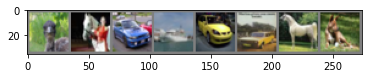

 bird horse   car  ship   car   car horse   dog
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> tensor([2, 7, 1, 8, 1, 1, 7, 5])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print(type(images), images.shape)
print(type(labels), labels)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer=3, act='relu'):
        super(MLP, self).__init__()        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        # Construct Model
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))        
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

In [6]:
net = MLP(in_dim=3*1024, out_dim=10, hid_dim=100, n_layer=4, act='relu')
net

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [8]:
from tqdm.notebook import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

for epoch in tqdm(range(10)):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    
    # Train
    net.train()
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 3072) # -1은 원래의 shape에서 n*3072 차원을 만족하는 n을 알아서 계산
        # 순서가 중요할 때는 axis swap이란 것이 존재한다. 참고할 것. ex) 4*3*32*32 -> 4*32*32*3

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.188
[1,  4000] loss: 1.900
[1,  6000] loss: 1.741
[2,  2000] loss: 1.624
[2,  4000] loss: 1.587
[2,  6000] loss: 1.529
[3,  2000] loss: 1.474
[3,  4000] loss: 1.434
[3,  6000] loss: 1.446
[4,  2000] loss: 1.369
[4,  4000] loss: 1.358
[4,  6000] loss: 1.368
[5,  2000] loss: 1.295
[5,  4000] loss: 1.303
[5,  6000] loss: 1.295
[6,  2000] loss: 1.230
[6,  4000] loss: 1.253
[6,  6000] loss: 1.261
[7,  2000] loss: 1.174
[7,  4000] loss: 1.207
[7,  6000] loss: 1.220
[8,  2000] loss: 1.148
[8,  4000] loss: 1.153
[8,  6000] loss: 1.175
[9,  2000] loss: 1.103
[9,  4000] loss: 1.132
[9,  6000] loss: 1.133
[10,  2000] loss: 1.067
[10,  4000] loss: 1.095
[10,  6000] loss: 1.109

Finished Training


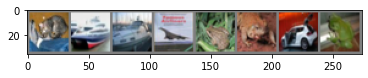

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.view(-1, 3072)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 52 %
